In [10]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Define seed for reproducibility
np.random.seed(42)

# Parameters
n_records = 100000
n_customers = 100
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)

# Medication details
medicines = {
    'Aspirin': {'price': 5.0, 'type': 'Acute'},  # Used occasionally
    'Paracetamol': {'price': 3.5, 'type': 'Acute'},
    'Ibuprofen': {'price': 4.0, 'type': 'Acute'},
    'Omeprazole': {'price': 8.0, 'type': 'Chronic'},  # Regular use
    'Metformin': {'price': 12.0, 'type': 'Chronic'}
}

# Generate customers with preferences
customers = []
for i in range(1, n_customers + 1):
    # Each customer has a preference for one chronic medication and may buy others occasionally
    chronic_med = np.random.choice([m for m, d in medicines.items() if d['type'] == 'Chronic'])
    customers.append({
        'id': i,
        'preferred_chronic_med': chronic_med,
        'acute_meds': [m for m in medicines.keys() if m != chronic_med]
    })

# Generate records
records = []
current_date = start_date
while current_date <= end_date:
    for customer in customers:
        # Chronic medication: Regular purchase
        if medicines[customer['preferred_chronic_med']]['type'] == 'Chronic':
            if np.random.rand() < 0.9:  # 90% chance of buying chronic medication
                records.append({
                    'Customer_ID': customer['id'],
                    'Medicine': customer['preferred_chronic_med'],
                    'Pickup_Date': current_date,
                    'Quantity': np.random.randint(1, 4),
                    'Price': medicines[customer['preferred_chronic_med']]['price']
                })

        # Acute medications: Occasional purchase
        for med in customer['acute_meds']:
            if np.random.rand() < 0.1:  # 10% chance of buying acute medication
                records.append({
                    'Customer_ID': customer['id'],
                    'Medicine': med,
                    'Pickup_Date': current_date,
                    'Quantity': np.random.randint(1, 3),
                    'Price': medicines[med]['price']
                })

    # Move to the next day
    current_date += timedelta(days=1)

# Create DataFrame
df = pd.DataFrame(records)

# Add seasonality
df['Month'] = df['Pickup_Date'].dt.month
df['Seasonality'] = np.where(df['Month'].isin([12, 1]), 'High',
                             np.where(df['Month'].isin([6, 7]), 'Medium', 'Low'))

# Calculate average interval between purchases
df['Average_Interval'] = df.groupby(['Customer_ID', 'Medicine'])['Pickup_Date'].diff().dt.days.fillna(0)

# Purchase frequency
df['Frequency'] = df.groupby(['Customer_ID', 'Medicine'])['Quantity'].transform('count')

# Total expenditure per purchase
df['Total_Expenditure'] = df['Quantity'] * df['Price']

# Add random noise to quantities and prices
df['Quantity'] = df['Quantity'] + np.random.normal(0, 0.5, len(df)).clip(min=1).round(0).astype(int)
df['Price'] = df['Price'] + np.random.normal(0, 0.5, len(df)).clip(min=1).round(2)

# Normalise continuous variables
for col in ['Average_Interval', 'Frequency', 'Total_Expenditure']:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

# Calculate days since the start of the dataset
df['Days_Since_Start'] = (df['Pickup_Date'] - start_date).dt.days

# Calculate moving average for 'Quantity'
# Modify window as needed
window_size = 7
df['Moving_Average'] = df.groupby('Medicine')['Quantity'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

# Now save the dataset
df.to_csv('pharmacy_dataset_optimised.csv', index=False)
# Display the first few rows
print(df.head())


   Customer_ID     Medicine Pickup_Date  Quantity  Price  Month Seasonality  \
0            2      Aspirin  2024-01-01         2    6.0      1        High   
1            3   Omeprazole  2024-01-01         4    9.0      1        High   
2            4   Omeprazole  2024-01-01         4    9.0      1        High   
3            4  Paracetamol  2024-01-01         2    4.5      1        High   
4            5   Omeprazole  2024-01-01         4    9.0      1        High   

   Average_Interval  Frequency  Total_Expenditure  Days_Since_Start  \
0         -0.565736  -1.474441          -1.170703                 0   
1         -0.565736   0.626506           0.727920                 0   
2         -0.565736   0.656201           0.727920                 0   
3         -0.565736  -1.504137          -1.320594                 0   
4         -0.565736   0.715592           0.727920                 0   

   Moving_Average  
0             2.0  
1             4.0  
2             4.0  
3             2.0 

Dataset loaded and prepared successfully.
Cross-Validation (Mean RMSE): 0.09
Model trained. MSE: 0.01, RMSE: 0.10, MAE: 0.07, R²: 0.85


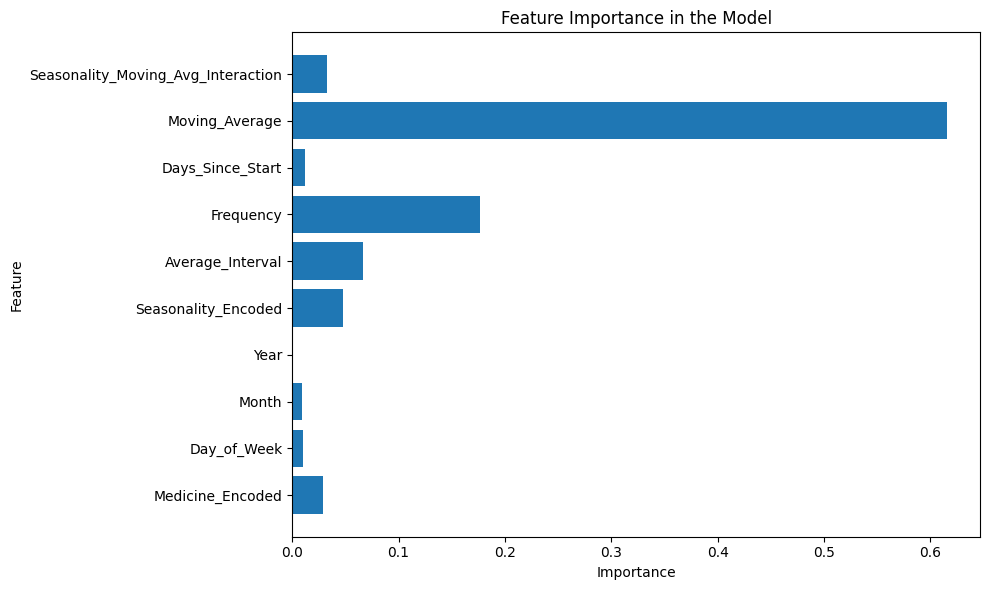

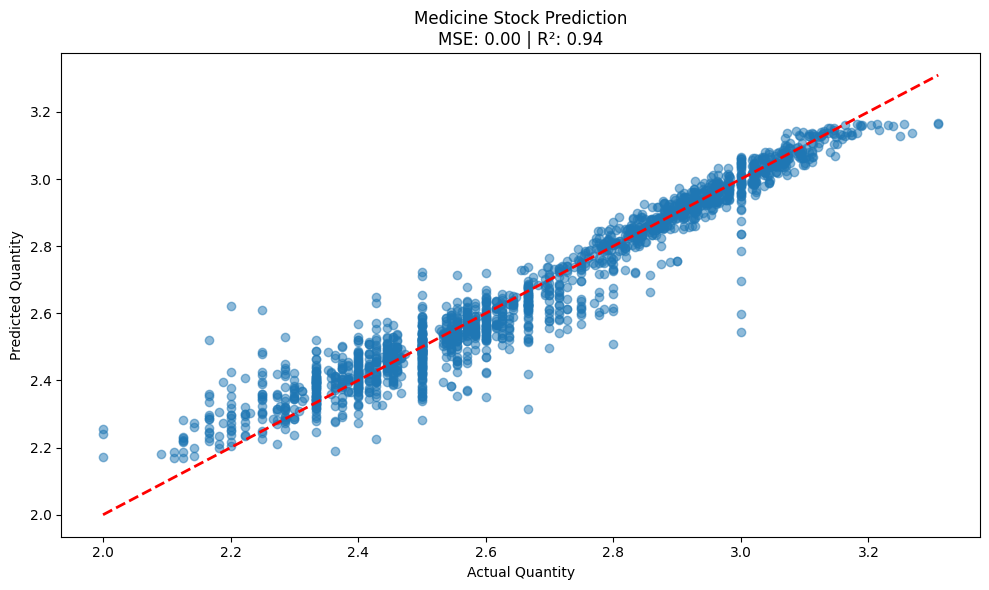

Predicted stock for Aspirin on 2025-06-15: 2 units


In [11]:
from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

class PharmacyPredictor:
    def __init__(self):
        self.model = None
        self.le_medicine = LabelEncoder()
        self.le_seasonality = LabelEncoder()
        self.df = None

    def load_dataset(self, filepath):
        """Load the dataset and prepare it for modelling."""
        self.df = pd.read_csv(filepath)
        if 'Moving_Average' not in self.df.columns:
            raise KeyError("The dataset is missing the 'Moving_Average' column. Please regenerate the dataset.")

        self.df['Pickup_Date'] = pd.to_datetime(self.df['Pickup_Date'])
        self.prepare_data()
        print("Dataset loaded and prepared successfully.")

    def prepare_data(self):
        """Extract temporal and categorical features from the dataset."""
        # Extract temporal features
        self.df['Day_of_Week'] = self.df['Pickup_Date'].dt.dayofweek
        self.df['Month'] = self.df['Pickup_Date'].dt.month
        self.df['Year'] = self.df['Pickup_Date'].dt.year

        # Encode categorical variables
        self.df['Medicine_Encoded'] = self.le_medicine.fit_transform(self.df['Medicine'])
        self.df['Seasonality_Encoded'] = self.le_seasonality.fit_transform(self.df['Seasonality'])

        # Create interaction features
        self.df['Seasonality_Moving_Avg_Interaction'] = (
            self.df['Seasonality_Encoded'] * self.df['Moving_Average']
        )

        # Aggregate data by date and medicine to calculate average quantities
        self.df_aggregated = self.df.groupby(
            ['Pickup_Date', 'Medicine', 'Medicine_Encoded', 'Day_of_Week', 'Month', 'Year', 'Seasonality_Encoded']
        )[['Quantity', 'Average_Interval', 'Frequency', 'Days_Since_Start', 'Moving_Average',
           'Seasonality_Moving_Avg_Interaction']].mean().reset_index()

    def train_model(self):
        """Train an XGBoost regression model using cross-validation."""
        # Define features and target
        X = self.df_aggregated[['Medicine_Encoded', 'Day_of_Week', 'Month', 'Year',
                                'Seasonality_Encoded', 'Average_Interval',
                                'Frequency', 'Days_Since_Start', 'Moving_Average',
                                'Seasonality_Moving_Avg_Interaction']]
        y = self.df_aggregated['Quantity']

        # Split into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialise XGBoost Regressor with tuned hyperparameters
        self.model = XGBRegressor(
            n_estimators=600,
            learning_rate=0.02,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.7,
            reg_alpha=0.5,
            reg_lambda=1,
            random_state=42
        )

        # Perform K-Fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores_rmse = []

        for train_index, val_index in kf.split(X_train):
            X_ktrain, X_kval = X_train.iloc[train_index], X_train.iloc[val_index]
            y_ktrain, y_kval = y_train.iloc[train_index], y_train.iloc[val_index]

            # Train the model on the current fold
            self.model.fit(X_ktrain, y_ktrain)

            # Predict and evaluate
            y_kval_pred = self.model.predict(X_kval)
            rmse_kfold = np.sqrt(mean_squared_error(y_kval, y_kval_pred))
            cv_scores_rmse.append(rmse_kfold)

        print(f"Cross-Validation (Mean RMSE): {np.mean(cv_scores_rmse):.2f}")

        # Train the model on the full training set
        self.model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = self.model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse_final = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        print(f"Model trained. MSE: {mse:.2f}, RMSE: {rmse_final:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

    def visualise_results(self, y_test, y_pred):
        """Visualise the predicted vs actual values."""
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel("Actual Quantity")
        plt.ylabel("Predicted Quantity")
        plt.title(f"Medicine Stock Prediction\nMSE: {mean_squared_error(y_test, y_pred):.2f} | R²: {r2_score(y_test, y_pred):.2f}")
        plt.tight_layout()
        plt.show()

    def analyse_feature_importance(self):
        """Analyse feature importance in the trained model."""
        importances = self.model.feature_importances_
        feature_names = ['Medicine_Encoded', 'Day_of_Week', 'Month', 'Year',
                         'Seasonality_Encoded', 'Average_Interval',
                         'Frequency', 'Days_Since_Start', 'Moving_Average',
                         'Seasonality_Moving_Avg_Interaction']

        plt.figure(figsize=(10, 6))
        plt.barh(feature_names, importances)
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title("Feature Importance in the Model")
        plt.tight_layout()
        plt.show()

    def predict_stock(self, medicine, pickup_date):
        """Predict stock for a given medicine and date."""
        # Encode the medicine
        medicine_encoded = self.le_medicine.transform([medicine])[0]

        # Extract date information
        day_of_week = pickup_date.weekday()
        month = pickup_date.month
        year = pickup_date.year

        # Encode seasonality based on the month
        seasonality_encoded = self.le_seasonality.transform(
            ['High' if month in [12, 1] else ('Medium' if month in [6, 7] else 'Low')]
        )[0]

        # Calculate days since the start of the dataset
        days_since_start = (pickup_date - datetime(2024, 1, 1)).days

        # Estimate default values for other features
        average_interval = 0.0  # Can be adjusted based on historical data
        frequency = 0.0         # Can be adjusted based on historical data
        moving_average = 0.0    # Can be adjusted based on historical data
        seasonality_moving_avg_interaction = seasonality_encoded * moving_average

        # Create input array for prediction
        input_array = np.array([[medicine_encoded, day_of_week, month, year,
                                 seasonality_encoded, average_interval,
                                 frequency, days_since_start,
                                 moving_average, seasonality_moving_avg_interaction]])

        # Make prediction
        prediction = self.model.predict(input_array)
        return round(prediction[0])

# Example usage:
predictor = PharmacyPredictor()

# Load the dataset and train the model
predictor.load_dataset('pharmacy_dataset_optimised.csv')
predictor.train_model()

# Analyse feature importance
predictor.analyse_feature_importance()

# Visualise results
predictor.visualise_results(
    predictor.df_aggregated['Quantity'],
    predictor.model.predict(predictor.df_aggregated[['Medicine_Encoded', 'Day_of_Week', 'Month', 'Year',
                                                     'Seasonality_Encoded', 'Average_Interval',
                                                     'Frequency', 'Days_Since_Start', 'Moving_Average',
                                                     'Seasonality_Moving_Avg_Interaction']])
)

# Example prediction
example_date = datetime(2025, 6, 15)
predicted_stock = predictor.predict_stock('Aspirin', example_date)
print(f"Predicted stock for Aspirin on {example_date.date()}: {predicted_stock} units")

Cross-Validation Metrics:
   Fold      RMSE       MAE        R²
0     1  0.102926  0.069436  0.841447
1     2  0.093842  0.065061  0.880090
2     3  0.087361  0.061280  0.893947
3     4  0.091660  0.066478  0.880275
4     5  0.086429  0.061948  0.895641


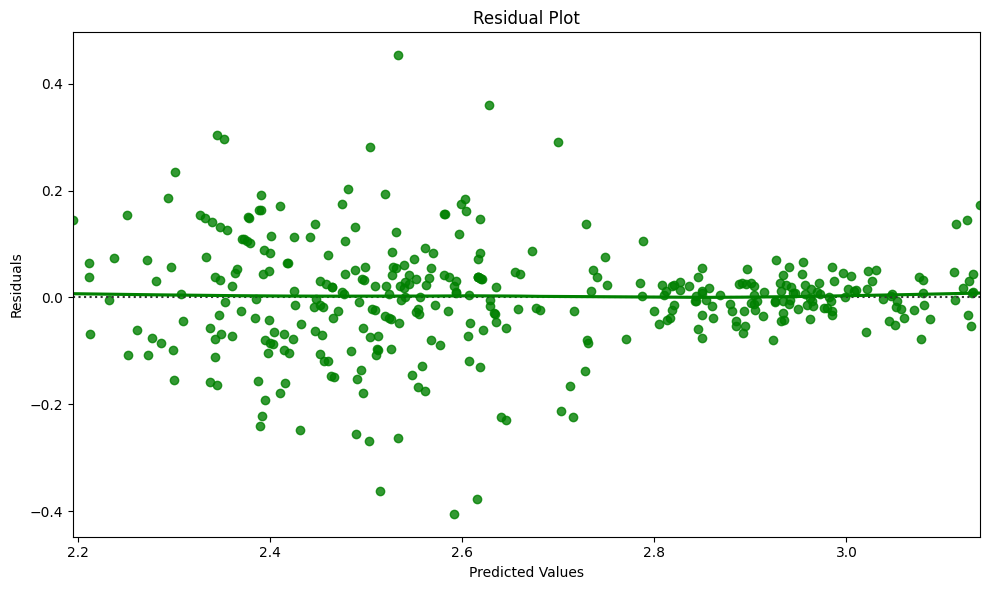

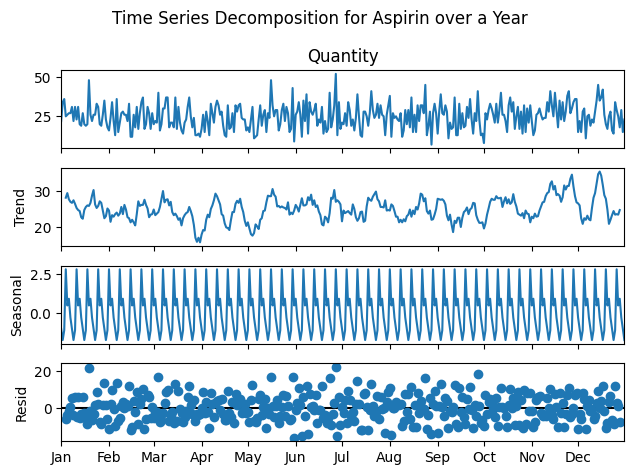

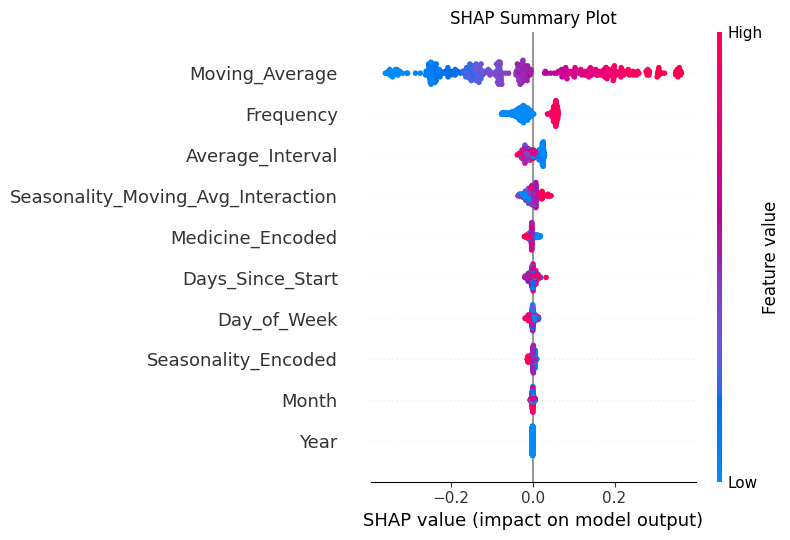

Example Predictions:
      Medicine        Date  Predicted Stock
0      Aspirin  2025-06-15                2
1      Aspirin  2025-07-01                2
2      Aspirin  2025-08-10                2
3  Paracetamol  2025-06-15                2
4  Paracetamol  2025-07-01                2
5  Paracetamol  2025-08-10                2
6   Omeprazole  2025-06-15                2
7   Omeprazole  2025-07-01                2
8   Omeprazole  2025-08-10                2


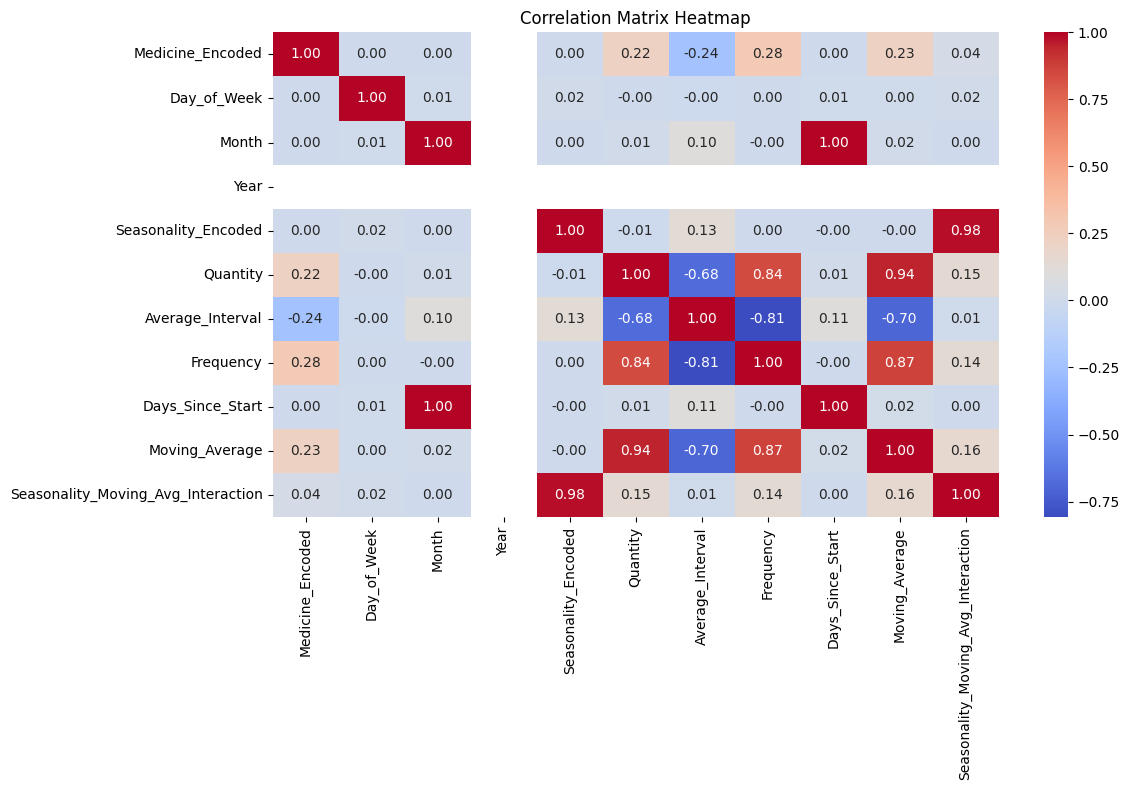

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming `predictor` is already initialized and trained
X = predictor.df_aggregated[['Medicine_Encoded', 'Day_of_Week', 'Month', 'Year',
                             'Seasonality_Encoded', 'Average_Interval',
                             'Frequency', 'Days_Since_Start', 'Moving_Average',
                             'Seasonality_Moving_Avg_Interaction']]
y = predictor.df_aggregated['Quantity']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Predict on test set
y_pred = predictor.model.predict(X_test)

# 1. Cross-Validation Metrics Table
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rmse = []
cv_scores_mae = []
cv_scores_r2 = []

for train_index, val_index in kf.split(X_train):
    X_ktrain, X_kval = X_train.iloc[train_index], X_train.iloc[val_index]
    y_ktrain, y_kval = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the current fold
    predictor.model.fit(X_ktrain, y_ktrain)

    # Predict and evaluate
    y_kval_pred = predictor.model.predict(X_kval)
    rmse_kfold = np.sqrt(mean_squared_error(y_kval, y_kval_pred))
    mae_kfold = mean_absolute_error(y_kval, y_kval_pred)
    r2_kfold = r2_score(y_kval, y_kval_pred)

    cv_scores_rmse.append(rmse_kfold)
    cv_scores_mae.append(mae_kfold)
    cv_scores_r2.append(r2_kfold)

# Create a DataFrame for cross-validation metrics
cv_metrics_df = pd.DataFrame({
    'Fold': range(1, 6),
    'RMSE': cv_scores_rmse,
    'MAE': cv_scores_mae,
    'R²': cv_scores_r2
})

# Save or display the table
print("Cross-Validation Metrics:")
print(cv_metrics_df)

# 2. Residual Analysis Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, color="g")
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

# 3. Time Series Decomposition (for one medication, e.g., Aspirin)
aspirin_data = predictor.df[predictor.df['Medicine'] == 'Aspirin']
aspirin_data = aspirin_data.groupby('Pickup_Date')['Quantity'].sum().reset_index()

# Converte a coluna de datas para datetime (caso ainda não esteja)
aspirin_data['Pickup_Date'] = pd.to_datetime(aspirin_data['Pickup_Date'])

# Define a coluna 'Pickup_Date' como índice para o seasonal_decompose
decomposition = seasonal_decompose(aspirin_data.set_index('Pickup_Date')['Quantity'], model='additive')

fig = decomposition.plot()
fig.suptitle("Time Series Decomposition for Aspirin over a Year")
plt.tight_layout()

for ax in fig.axes:
    # Define o formato desejado para as datas (ex.: "MM")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    # Define automaticamente os intervalos dos rótulos de data
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.show()


# 4. SHAP Values for Feature Importance (Optional, requires SHAP library)
import shap

# Explain the model's predictions using SHAP values
explainer = shap.Explainer(predictor.model)
shap_values = explainer.shap_values(X_test)

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()

# 5. Example Predictions Table
example_dates = [datetime(2025, 6, 15), datetime(2025, 7, 1), datetime(2025, 8, 10)]
medicines = ['Aspirin', 'Paracetamol', 'Omeprazole']

predictions = []
for medicine in medicines:
    for date in example_dates:
        predicted_stock = predictor.predict_stock(medicine, date)
        predictions.append({
            'Medicine': medicine,
            'Date': date.date(),
            'Predicted Stock': predicted_stock
        })

# Create a DataFrame for predictions
predictions_df = pd.DataFrame(predictions)
print("Example Predictions:")
print(predictions_df)

# 6. Correlation Matrix Heatmap
# Corrected Correlation Matrix Calculation
numeric_columns = predictor.df_aggregated.select_dtypes(include=[np.number]).columns
correlation_matrix = predictor.df_aggregated[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()